# <I><U><U>STARTUP SUCCESS PREDCITION

### <B>Objective:
    
    To construct a model that can forecast the success of a StartUp on the basis of different variables and to  determine which factors facilitates most in the success of a startup.
    

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats
from scipy.stats import norm, skew 

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots


from sklearn.preprocessing import StandardScaler as ss

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer

from xgboost.sklearn import XGBClassifier

<b>Loading the dataset:

In [2]:
data = pd.read_csv("/Users/gauravsharma/Documents/BDDA/data_files/startups_data.csv",  encoding='latin-1')

## Data Exploration:

In [3]:
data.head(5)

,name,market,funding_total_usd,status,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,Verizon Communications,Mobile,30079503000,ipo,USA,NY,New York,5,2015-04-19,2010-01-26,2014-02-28
1,Uber,Real Time,7007450000,operating,USA,CA,San Francisco,12,NaN,2009-08-01,2015-08-19
2,Sberbank,Finance,5800000000,ipo,RUS,NaN,Moscow,1,2014-04-01,2014-07-07,2014-07-07
3,Clearwire,Mobile,5720000000,acquired,USA,WA,Kirkland,5,2012-06-01,2001-12-11,2013-02-27
4,Charter Communications,Telecommunications,5162513431,ipo,USA,CT,Stamford,2,NaN,2009-11-21,2014-09-15


In [4]:
# Data Size
data.shape

(61398, 11)

In [5]:
# Description
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61398 entries, 0 to 61397
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               61397 non-null  object
 1   market             58641 non-null  object
 2   funding_total_usd  61398 non-null  int64 
 3   status             61398 non-null  object
 4   country_code       55886 non-null  object
 5   state_code         37224 non-null  object
 6   city               54881 non-null  object
 7   funding_rounds     61398 non-null  int64 
 8   founded_at         47789 non-null  object
 9   first_funding_at   61385 non-null  object
 10  last_funding_at    61398 non-null  object
dtypes: int64(2), object(9)
memory usage: 5.2+ MB


In [6]:
data.columns

Index(['name', 'market', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at'],
      dtype='object')

In [7]:
# Re-odering columns
data = data[['name', 'market', 'funding_total_usd', 'country_code',
       'state_code', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'status']]

data.head(5)

,name,market,funding_total_usd,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,status
0,Verizon Communications,Mobile,30079503000,USA,NY,New York,5,2015-04-19,2010-01-26,2014-02-28,ipo
1,Uber,Real Time,7007450000,USA,CA,San Francisco,12,NaN,2009-08-01,2015-08-19,operating
2,Sberbank,Finance,5800000000,RUS,NaN,Moscow,1,2014-04-01,2014-07-07,2014-07-07,ipo
3,Clearwire,Mobile,5720000000,USA,WA,Kirkland,5,2012-06-01,2001-12-11,2013-02-27,acquired
4,Charter Communications,Telecommunications,5162513431,USA,CT,Stamford,2,NaN,2009-11-21,2014-09-15,ipo


<B>Numeric Columns

In [8]:
num_col = ['funding_total_usd', 'funding_rounds']

cat_col = ['name', 'market', 'status', 'country_code', 'state_code', 'city', 'founded_at', 'first_funding_at', 'last_funding_at']

<b>Target Column: "Status"
    
    The target variable, if a startup is ‘acquired’ by some other organization, means the startup succeed

In [9]:
data.status.nunique()

4

In [10]:
# Changing values of target column
data['status'] = data.status.map({'acquired':1, 'operating':0 ,'ipo':0, 'closed':0})

# Changing data type of target column as: int
data['status'].astype(int)

0        0
1        0
2        0
3        1
4        0
        ..
61393    0
61394    0
61395    0
61396    0
61397    0
Name: status, Length: 61398, dtype: int64

## Exploratory Data Analysis and Developing Insights with Data Visualization:

<b> Statistical Summary

In [11]:
data.describe()

,funding_total_usd,funding_rounds,status
count,6.139800e+04,61398.000000,61398.000000
mean,1.387271e+07,1.715854,0.078911
std,1.498299e+08,1.329826,0.269603
min,0.000000e+00,1.000000,0.000000
25%,4.000000e+04,1.000000,0.000000
50%,9.535530e+05,1.000000,0.000000
75%,6.314039e+06,2.000000,0.000000
max,3.007950e+10,19.000000,1.000000


<B>Missing Values

In [12]:
null=pd.DataFrame(data.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(data.isna().sum()/len(data)*100)
null = null[null["% Missing Values"] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1)

,Null Values,% Missing Values
name,1,0.001629
market,2757,4.490374
country_code,5512,8.977491
state_code,24174,39.372618
city,6517,10.614352
founded_at,13609,22.165217
first_funding_at,13,0.021173


In [13]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
print(pd.DataFrame(imp.fit_transform(data[['name', 'market', 'status', 'country_code', 'state_code', 'city', 'founded_at', 'first_funding_at', 'last_funding_at']]),
                   columns=cat_col,
                   index=data.index))

                              name                market status country_code  \
0           Verizon Communications                Mobile      0          USA   
1                             Uber             Real Time      0          USA   
2                         Sberbank               Finance      0          RUS   
3                        Clearwire                Mobile      1          USA   
4           Charter Communications    Telecommunications      0          USA   
...                            ...                   ...    ...          ...   
61393                   Zymr, Inc.  Cloud Infrastructure      0          USA   
61394  Zynergy Projects & Services      Clean Technology      0          IND   
61395                         Zype                 Video      0          USA   
61396                        [24]7  Predictive Analytics      0          USA   
61397                ??? ChiShenMa           Restaurants      0          CHN   

      state_code           city  founde

In [14]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
print(pd.DataFrame(imp.fit_transform(data[['funding_total_usd', 'funding_rounds']]),
                   columns=num_col,
                   index=data.index))

       funding_total_usd  funding_rounds
0           3.007950e+10             5.0
1           7.007450e+09            12.0
2           5.800000e+09             1.0
3           5.720000e+09             5.0
4           5.162513e+09             2.0
...                  ...             ...
61393       0.000000e+00             3.0
61394       0.000000e+00             1.0
61395       0.000000e+00             1.0
61396       0.000000e+00             1.0
61397       0.000000e+00             1.0

[61398 rows x 2 columns]


<B>Correlation Heatmap

In [15]:
# Lable encoding data
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
data = data.apply(LabelEncoder().fit_transform)

In [16]:
data.corr()

,name,market,funding_total_usd,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,status
name,1.000000,0.034913,-0.030722,-0.029301,0.031589,0.006910,-0.004532,-0.004763,0.008035,0.004028,-0.000425
market,0.034913,1.000000,-0.116139,0.013429,0.060261,0.050475,-0.086485,-0.003977,-0.016181,-0.066467,0.018279
funding_total_usd,-0.030722,-0.116139,1.000000,0.050057,-0.169689,-0.062332,0.490825,-0.018435,-0.345347,-0.063958,0.178460
country_code,-0.029301,0.013429,0.050057,1.000000,-0.509765,0.113712,0.067492,-0.000523,-0.036731,-0.008843,0.064114
state_code,0.031589,0.060261,-0.169689,-0.509765,1.000000,0.063262,-0.139650,0.005477,0.089885,0.022770,-0.105155
city,0.006910,0.050475,-0.062332,0.113712,0.063262,1.000000,-0.051188,-0.000419,0.023278,-0.005106,-0.004756
funding_rounds,-0.004532,-0.086485,0.490825,0.067492,-0.139650,-0.051188,1.000000,-0.010530,-0.277562,0.180883,0.075050
founded_at,-0.004763,-0.003977,-0.018435,-0.000523,0.005477,-0.000419,-0.010530,1.000000,0.011125,0.002918,-0.008292
first_funding_at,0.008035,-0.016181,-0.345347,-0.036731,0.089885,0.023278,-0.277562,0.011125,1.000000,0.834922,-0.316010
last_funding_at,0.004028,-0.066467,-0.063958,-0.008843,0.022770,-0.005106,0.180883,0.002918,0.834922,1.000000,-0.293385


(11.5, -0.5)

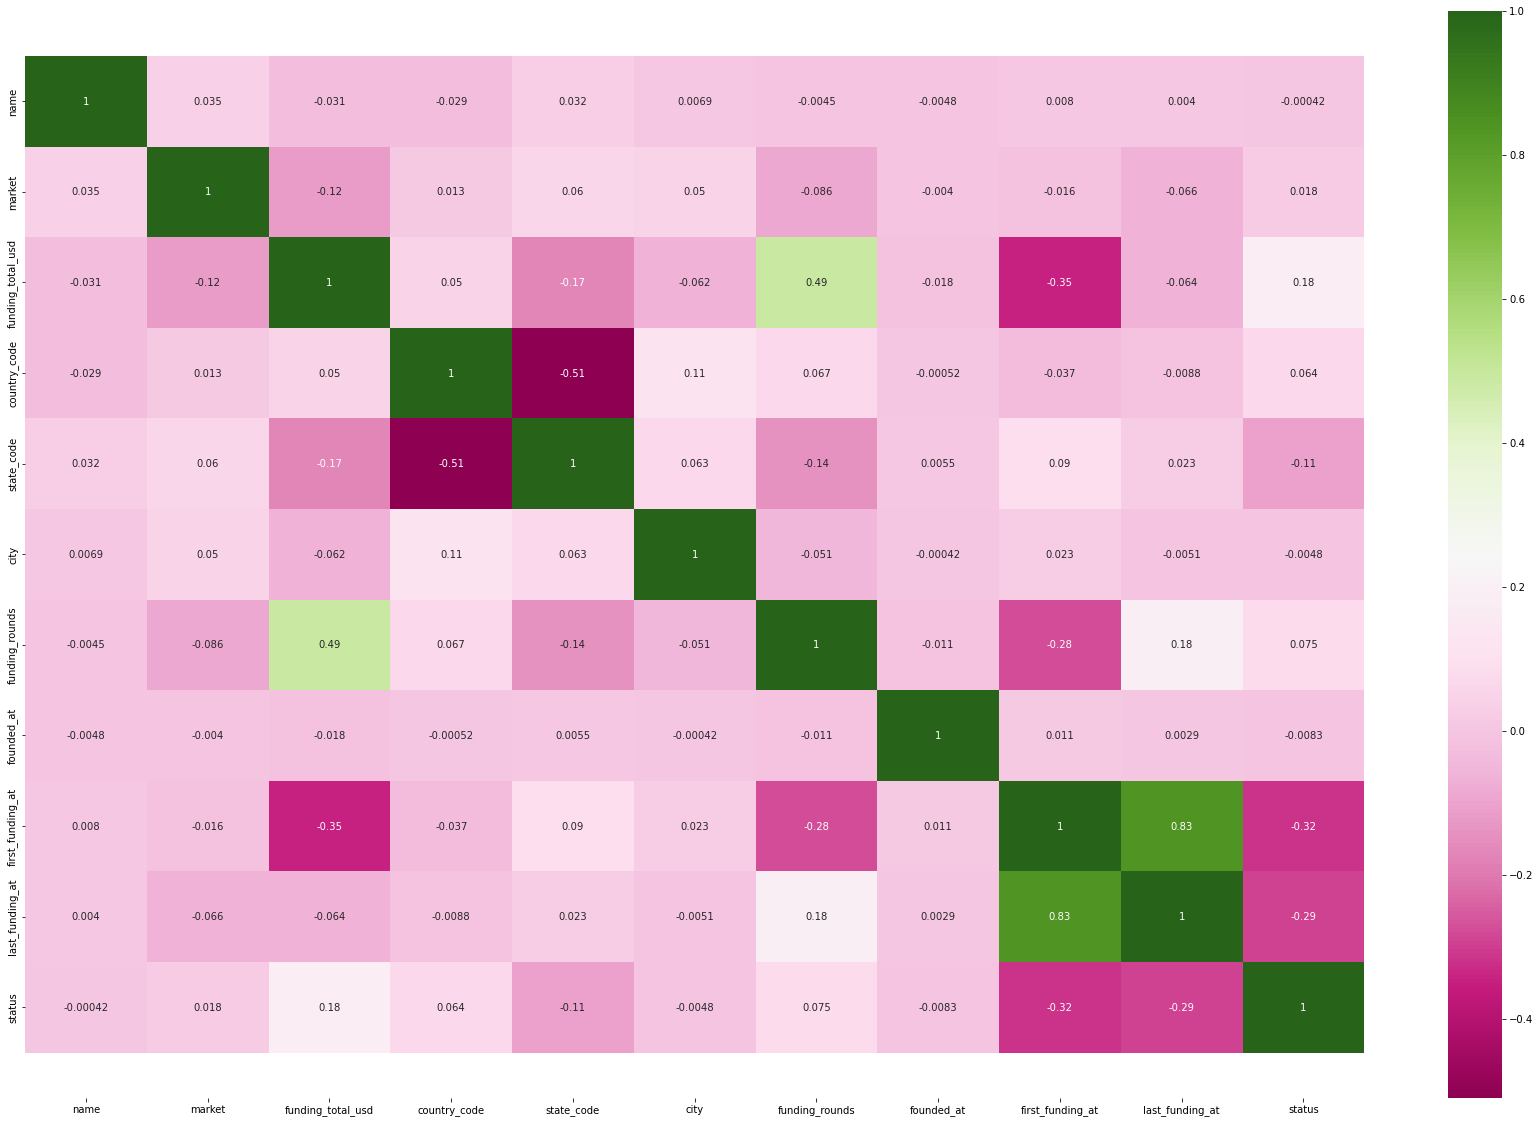

In [17]:
plt.figure(figsize=(30,20))
ax = sns.heatmap(data = data.corr(),cmap='PiYG',annot=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5,top - 0.5)

<b> Scatter Plot

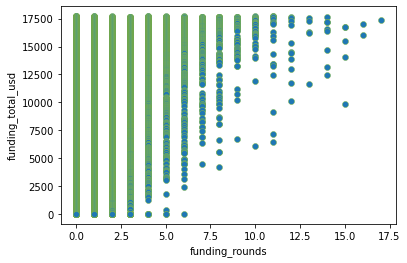

In [18]:
fig, ax = plt.subplots()
_ = plt.scatter(x=data['funding_rounds'], y=data['funding_total_usd'], edgecolors='#7eb54e', linewidths= 0.5)
_ = ax.set(xlabel="funding_rounds", ylabel="funding_total_usd")

<b>How many Startup are acquired or closed

In [19]:
data_acquired = data[(data["status"] == True)]
data_acquired.shape

(4845, 11)

In [20]:
data_closed = data[(data["status"] == False)]
data_closed.shape

(56553, 11)

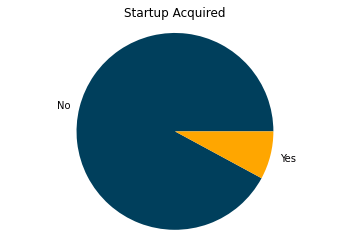

In [21]:
value_counts = data["status"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie(x=[value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
           colors=['#003f5c', '#ffa600'], textprops={'color': '#040204'})
_ = ax.axis('equal')
_ = ax.set_title('Startup Acquired')

<b>Which market has the largest number of startup

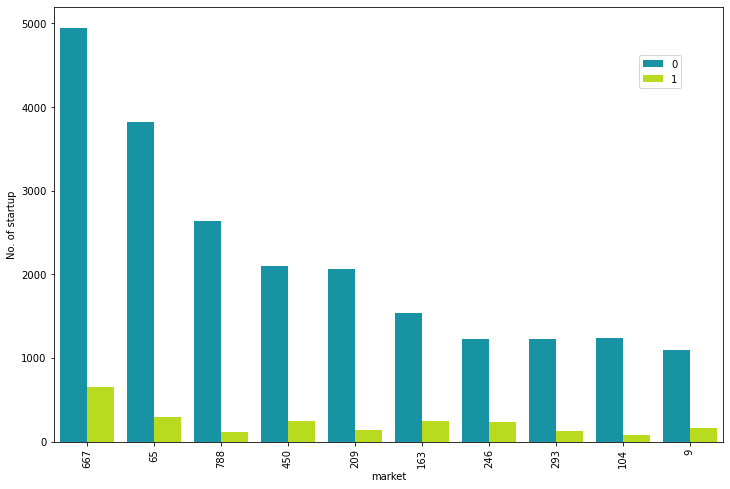

In [22]:

fig, ax = plt.subplots(figsize=(12,8))

_ = sns.countplot(x="market", hue="status", data=data, palette="nipy_spectral",
              order=data.market.value_counts().iloc[:10].index)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="market", ylabel="No. of startup")
plt.legend(bbox_to_anchor=(0.945, 0.90))


<b>Which city has the largest number of startup

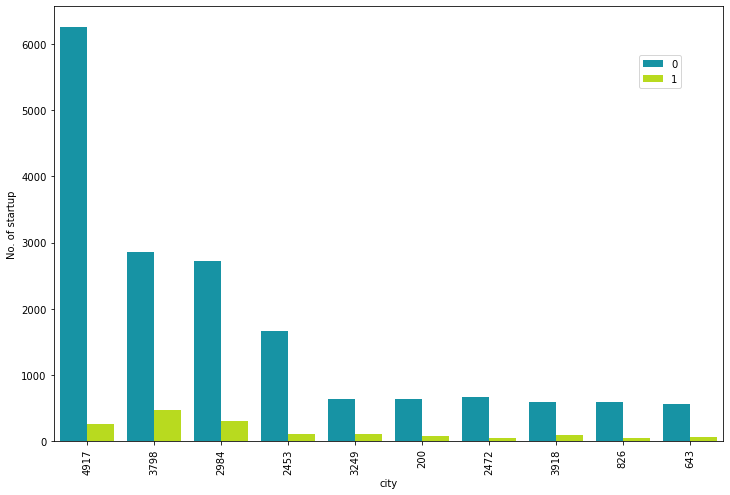

In [23]:
fig, ax = plt.subplots(figsize=(12,8))

_ = sns.countplot(x="city", hue="status", data=data, palette="nipy_spectral",
              order=data.city.value_counts().iloc[:10].index)

_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="city", ylabel="No. of startup")
plt.legend(bbox_to_anchor=(0.945, 0.90))

<b>Which Market has the largest number Success Rate

In [24]:
data1 = data[data['status']==1].groupby(['market']).agg({'status':'count'}).reset_index()
data1.columns=['market','total_success']

data2 = data[data['status']==0].groupby(['market']).agg({'status':'count'}).reset_index()
data2.columns=['market','total_closed']

data3=data.groupby(['market']).agg({'status':'count'}).reset_index()
data3.columns=['market','total_startup']

data1= data1.merge(data2, on='market')
data1= data1.merge(data3, on='market')

data1['success_rate']= round((data1['total_success'] / data1['total_startup']) * 100,2)

most_succes_rate = data1.sort_values('success_rate', ascending=False)
most_succes_rate

,market,total_success,total_closed,total_startup,success_rate
378,776,1,1,2,50.00
87,180,1,1,2,50.00
88,183,1,1,2,50.00
364,755,2,3,5,40.00
188,409,3,5,8,37.50
...,...,...,...,...,...
202,433,4,283,287,1.39
252,537,1,72,73,1.37
111,232,1,106,107,0.93
120,254,1,123,124,0.81


<b>Which City has the largest number Success Rate

In [25]:
data1 = data[data['status']==1].groupby(['city']).agg({'status':'count'}).reset_index()
data1.columns=['city','total_success']

data2 = data[data['status']==0].groupby(['city']).agg({'status':'count'}).reset_index()
data2.columns=['city','total_closed']

data3=data.groupby(['city']).agg({'status':'count'}).reset_index()
data3.columns=['city','total_startup']

data1= data1.merge(data2, on='city')
data1= data1.merge(data3, on='city')

data1['success_rate']= round((data1['total_success'] / data1['total_startup']) * 100,2)

most_succes_rate = data1.sort_values('success_rate', ascending=False)
most_succes_rate

,city,total_success,total_closed,total_startup,success_rate
327,2127,2,1,3,66.67
297,1875,2,1,3,66.67
733,4726,2,1,3,66.67
706,4604,2,1,3,66.67
12,65,2,1,3,66.67
...,...,...,...,...,...
304,1946,1,80,81,1.23
416,2681,1,86,87,1.15
632,3966,1,119,120,0.83
298,1885,1,143,144,0.69


<b><b>Which market having most number of total funding

In [26]:
funding_sorted_maket = pd.pivot_table(data,
              index=['market'],
              values=['funding_total_usd'],
              aggfunc=['sum']
              ).reset_index()
funding_sorted_maket.columns = ['market', 'funding_total_usd']
funding_sorted_maket = funding_sorted_maket.sort_values(['funding_total_usd'], ascending = False)
funding_sorted_maket.head(10)

,market,funding_total_usd
65,65,40090346
667,667,38274871
450,450,15061855
209,209,12866656
246,246,12206401
104,104,11954250
324,324,10883434
323,323,9388118
163,163,9215439
9,9,8782233


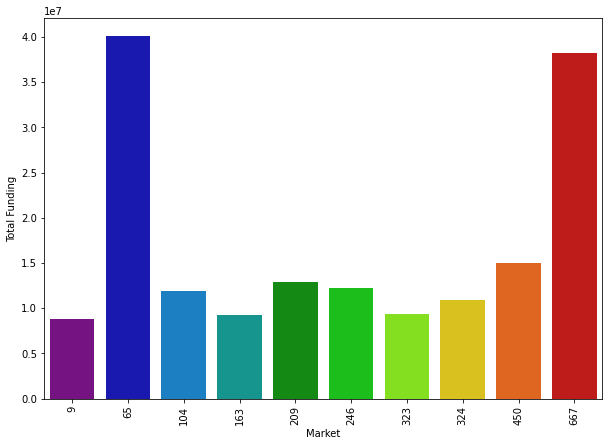

In [27]:
fig, ax = plt.subplots(figsize=(10,7))
_ = sns.barplot(x="market", y="funding_total_usd", data=funding_sorted_maket.head(10),
                palette="nipy_spectral", ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="Market", ylabel="Total Funding")

<b>Which city having most number of total funding

In [28]:
funding_sorted_city = pd.pivot_table(data,
              index=['city'],
              values=['funding_total_usd'],
              aggfunc=['sum']
              ).reset_index()
funding_sorted_city.columns = ['city', 'funding_total_usd']
funding_sorted_city = funding_sorted_city.sort_values(['funding_total_usd'], ascending = False)
funding_sorted_city = funding_sorted_city.head(10)
funding_sorted_city

,city,funding_total_usd
3798,3798,23962420
4917,4917,23904277
2984,2984,20503596
2453,2453,9640569
643,643,5575169
3249,3249,5558103
200,200,5356672
309,309,5321618
3918,3918,5192191
469,469,4940682


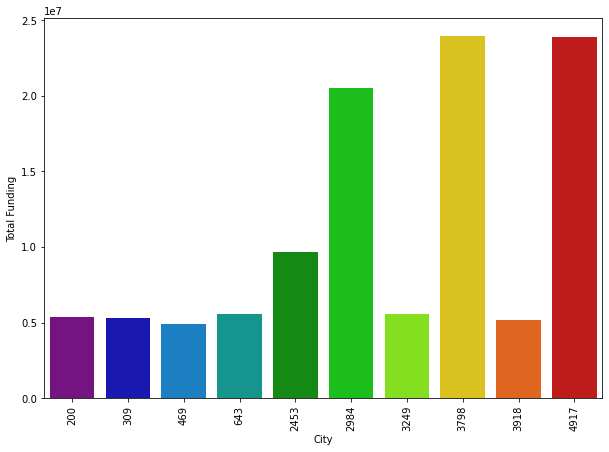

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
_ = sns.barplot(x="city", y="funding_total_usd", data=funding_sorted_city,
                palette="nipy_spectral", ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="City", ylabel="Total Funding")

## Feature Engineering (creating new features)

In [30]:
# Creating a new column 'diff' which is different between the last and first in year

data["last_funding_at"] = pd.to_datetime(data["last_funding_at"])
data["first_funding_at"] = pd.to_datetime(data["first_funding_at"], errors = 'coerce')

data['diff'] = (data['last_funding_at'] - data['first_funding_at'])/ np.timedelta64(1, 'Y')
data["diff"] = pd.to_numeric(data["diff"])
data.head(5)

,name,market,funding_total_usd,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,status,diff
0,54278,450,17706,128,40,2984,4,3749,1970-01-01 00:00:00.000002477,1970-01-01 00:00:00.000003644,0,3.698076e-14
1,53059,584,17705,128,6,3798,11,3828,1970-01-01 00:00:00.000002312,1970-01-01 00:00:00.000004181,0,5.922625e-14
2,43919,271,17704,108,61,2844,0,3408,1970-01-01 00:00:00.000004062,1970-01-01 00:00:00.000003773,0,-9.158045e-15
3,10566,450,17703,128,57,2177,4,2762,1970-01-01 00:00:00.000000499,1970-01-01 00:00:00.000003278,1,8.806300e-14
4,9786,703,17702,128,8,4130,1,3828,1970-01-01 00:00:00.000002418,1970-01-01 00:00:00.000003843,0,4.515645e-14


In [31]:
# Creating a new column 'growth' which reflect that a startup has gain and used average funding in average number of years with average number of year difference between first and last funding

data['growth'] = np.where((data['funding_total_usd'] >= data['funding_total_usd'].mean()) | (data['status'] == 1) | (data['diff'] >= data['diff'].mean()), 1, 0)
data.head(5)

,name,market,funding_total_usd,country_code,state_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,status,diff,growth
0,54278,450,17706,128,40,2984,4,3749,1970-01-01 00:00:00.000002477,1970-01-01 00:00:00.000003644,0,3.698076e-14,1
1,53059,584,17705,128,6,3798,11,3828,1970-01-01 00:00:00.000002312,1970-01-01 00:00:00.000004181,0,5.922625e-14,1
2,43919,271,17704,108,61,2844,0,3408,1970-01-01 00:00:00.000004062,1970-01-01 00:00:00.000003773,0,-9.158045e-15,1
3,10566,450,17703,128,57,2177,4,2762,1970-01-01 00:00:00.000000499,1970-01-01 00:00:00.000003278,1,8.806300e-14,1
4,9786,703,17702,128,8,4130,1,3828,1970-01-01 00:00:00.000002418,1970-01-01 00:00:00.000003843,0,4.515645e-14,1


## Discover if data possess any structure



In [32]:
# Selecting only numeric columns 
num_data = data.select_dtypes(include = ['float64', 'int64']).copy()
num_data.columns

Index(['name', 'market', 'funding_total_usd', 'country_code', 'state_code',
       'city', 'funding_rounds', 'founded_at', 'status', 'diff', 'growth'],
      dtype='object')

In [33]:
num_data.head(5)

,name,market,funding_total_usd,country_code,state_code,city,funding_rounds,founded_at,status,diff,growth
0,54278,450,17706,128,40,2984,4,3749,0,3.698076e-14,1
1,53059,584,17705,128,6,3798,11,3828,0,5.922625e-14,1
2,43919,271,17704,108,61,2844,0,3408,0,-9.158045e-15,1
3,10566,450,17703,128,57,2177,4,2762,1,8.806300e-14,1
4,9786,703,17702,128,8,4130,1,3828,0,4.515645e-14,1


In [34]:
num_data.shape

(61398, 11)

In [35]:
cols = ['funding_total_usd', 'funding_rounds', 'status', 'diff', 'growth']

In [36]:
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
cols = ['funding_total_usd', 'funding_rounds', 'status', 'diff', 'growth']
nc = ss.fit_transform(num_data.loc[:,cols])

In [37]:
nc.shape

(61398, 5)

In [38]:
nc = pd.DataFrame(nc, columns = cols)
nc.head(5)

,funding_total_usd,funding_rounds,status,diff,growth
0,2.138873,2.470019,-0.292698,1.953048,0.949605
1,2.138689,7.734722,-0.292698,3.156225,0.949605
2,2.138505,-0.538382,-0.292698,-0.542430,0.949605
3,2.138320,2.470019,3.416496,4.715899,0.949605
4,2.138136,0.213719,-0.292698,2.395242,0.949605


In [39]:
# Adding few columns that are discrete
# These columns were not to be scaled

nc['funding_total_usd'] = data['funding_total_usd']
nc['funding_rounds'] = data['funding_rounds']
nc['status'] = data['status']
nc['diff'] = data['diff']
nc['growth'] = data['growth']

In [40]:
# Creating a dataframe from random data for comparison:

rng = np.random.default_rng()
nc_rand = pd.DataFrame(rng.normal(size = (61398, 5)),
                       columns = cols )   

In [41]:
# 4.1 Add/overwrite these columns also
#
nc_rand['funding_total_usd'] = np.random.randint(2,   size= (61398,))   # [0,1]
nc_rand['funding_rounds']        = np.random.randint(2,   size= (61398,))   # [0,1]
nc_rand['status']       = np.random.randint(1,4, size= (61398,))   # [1,2,3]
nc_rand['diff']     = np.random.randint(24,  size= (61398,))   # [0 to 23]
nc_rand['growth']       = np.random.randint(7,   size= (61398,))   # [0 to 6]

nc_rand.shape    

(61398, 5)

<b> Parallel coordinates plot

Text(0.5, 1.0, 'Parallel chart with ad data')

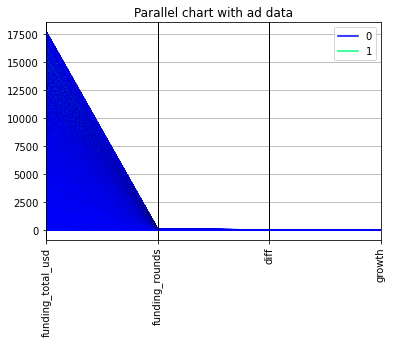

In [42]:
# Parallel coordinates with original data
fig2 = plt.figure()
ax = pd.plotting.parallel_coordinates(nc,
                                 'status',
                                  colormap= plt.cm.winter
                                  )

plt.xticks(rotation=90)
plt.title("Parallel chart with ad data")

Text(0.5, 1.0, 'Parallel chart with random data')

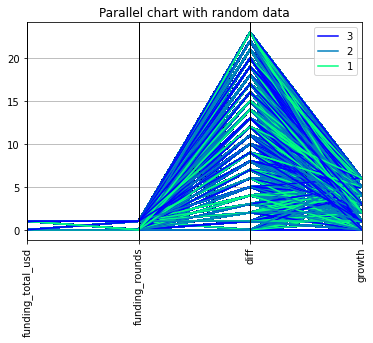

In [43]:
# Parallel coordinates with random data

fig1 = plt.figure()
pd.plotting.parallel_coordinates(nc_rand,
                                 'status',    # class_column
                                  colormap='winter'
                                  )
plt.xticks(rotation=90)
plt.title("Parallel chart with random data")

<b>Andrews plot

Text(0.5, 1.0, 'Andrews curve with ad data')

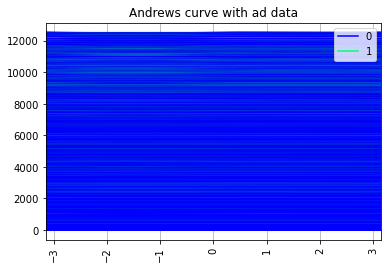

In [44]:
# 6.1 Andrews plots with original data
fig4 = plt.figure()
pd.plotting.andrews_curves(nc,
                           'status',
                            colormap = plt.cm.winter
                           )
plt.xticks(rotation=90)
plt.title("Andrews curve with ad data")

Text(0.5, 1.0, 'Andrews plots with random data')

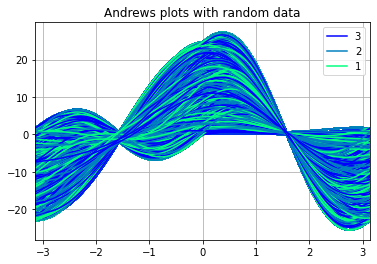

In [45]:
# 6.0 Andrews charts with random data
fig3 = plt.figure()
pd.plotting.andrews_curves(nc_rand,
                           'status',
                           colormap = 'winter')

plt.title("Andrews plots with random data")

<b>Radviz plot

<AxesSubplot:>

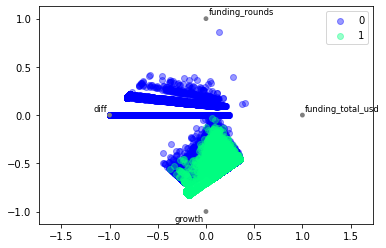

In [46]:
# 7.0 Radviz plot with original data

fig5 = plt.figure()
pd.plotting.radviz(nc,
                   class_column ='status',
                   colormap= plt.cm.winter,
                   alpha = 0.4
                   )

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/misc.py:178: RuntimeWarning: invalid value encountered in true_divide
  y = (s * row_).sum(axis=0) / row.sum()


<AxesSubplot:>

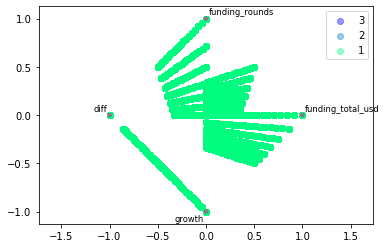

In [47]:
# 7.0 Radviz plot with random data

fig5 = plt.figure()
pd.plotting.radviz(nc_rand,
                   class_column ='status',
                   colormap= plt.cm.winter,
                   alpha = 0.4
                   )

## Data pipelining for Data Processing and Modeling

<b> Pre-processing

In [48]:
data.drop(columns = ['first_funding_at','last_funding_at'],inplace = True  )

In [49]:
data = data[['name', 'market', 'funding_total_usd', 'country_code', 'state_code',
        'city', 'funding_rounds', 'founded_at', 'diff', 'growth', 'status',]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61398 entries, 0 to 61397
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               61398 non-null  int64  
 1   market             61398 non-null  int64  
 2   funding_total_usd  61398 non-null  int64  
 3   country_code       61398 non-null  int64  
 4   state_code         61398 non-null  int64  
 5   city               61398 non-null  int64  
 6   funding_rounds     61398 non-null  int64  
 7   founded_at         61398 non-null  int64  
 8   diff               61398 non-null  float64
 9   growth             61398 non-null  int64  
 10  status             61398 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 5.2 MB


In [50]:
data['name'] = data['name'].astype(object)
data['market'] = data['market'].astype(object)
data['funding_total_usd'] = data['funding_total_usd'].astype(object)
data['country_code'] = data['country_code'].astype(object)
data['state_code'] = data['state_code'].astype(object)
data['city'] = data['city'].astype(object)
data['funding_rounds'] = data['funding_rounds'].astype(object)
data['founded_at'] = data['founded_at'].astype(object)
data['diff'] = data['diff'].astype(object)
data['growth'] = data['growth'].astype(object)
data['status'] = data['status'].astype(object)

In [51]:
# Divide data into predictors and target
# First 10 columns are predictors

X = data.iloc[ :, 0:10]
X.head(2)

# 10th index or 11th column is target
print("\n\nTarget,y, values")
y = data.iloc[ : , 10]
y.head()



Target,y, values


0    0
1    0
2    0
3    1
4    0
Name: status, dtype: object

<b>Split data into train and test

In [52]:
# Split dataset into train and validation parts
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20,
                                                    shuffle = True,
                                                    stratify = y
                                                    )      

In [53]:
X_train.shape

(49118, 10)

In [54]:
X_test.shape

(12280, 10)

In [55]:
y_train.shape

(49118,)

In [56]:
y_test.shape

(12280,)

In [57]:
# Storing column names somewhere for use in feature importance
colnames = X.columns.tolist()



<b> Creating a Pipeline

In [58]:

# Pipeline steps
# steps: List of (name, transform) tuples
#       (implementing fit/transform) that are
#       chained, in the order in which they
#       are chained, with the last object an
#       estimator.
#      Format: [(name, transformer), (name, transformer)..(name, estimator)]
from sklearn.preprocessing import StandardScaler as ss
steps_xg = [('sts', ss()),
            ('pca', PCA()),
            ('xg',  XGBClassifier(silent = False,
                                  n_jobs=3)        # Specify other parameters here
            )
            ]

# Instantiate Pipeline object

pipe_xg = Pipeline(steps_xg)



## Cross-Validation

<b>Grid Search code to discover best pipeline parameters

In [59]:
##################### DD. Grid Search #################

# Specify xgboost parameter-range
# Dictionary of parameters (16 combinations)
# Syntax: {
#          'transformerName__parameterName' : [ <listOfValues> ]
#              }
#
# What parameters in the pipe are available for tuning

print("\n\n--Which parameters can be tuned?--\n\n")
pipe_xg.get_params()




--Which parameters can be tuned?--




{'memory': None,
 'steps': [('sts', StandardScaler()),
  ('pca', PCA()),
  ('xg',
   XGBClassifier(base_score=None, booster=None, callbacks=None,
                 colsample_bylevel=None, colsample_bynode=None,
                 colsample_bytree=None, early_stopping_rounds=None,
                 enable_categorical=False, eval_metric=None, gamma=None,
                 gpu_id=None, grow_policy=None, importance_type=None,
                 interaction_constraints=None, learning_rate=None, max_bin=None,
                 max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
                 max_leaves=None, min_child_weight=None, missing=nan,
                 monotone_constraints=None, n_estimators=100, n_jobs=3,
                 num_parallel_tree=None, predictor=None, random_state=None,
                 reg_alpha=None, reg_lambda=None, ...))],
 'verbose': False,
 'sts': StandardScaler(),
 'pca': PCA(),
 'xg': XGBClassifier(base_score=None, booster=None, callbacks=None,
               c

Now that we know which parameters can be tuned, specify parameter space



In [60]:
#  Define dictionary
parameters = {'xg__learning_rate':  [0.03, 0.05], # learning rate decides what percentage
                                                  #  of error is to be fitted by
                                                  #   by next boosted tree.
                                                  # See this answer in stackoverflow:
                                                  # https://stats.stackexchange.com/questions/354484/why-does-xgboost-have-a-learning-rate
                                                  # Coefficients of boosted trees decide,
                                                  #  in the overall model or scheme, how much importance
                                                  #   each boosted tree shall have. Values of these
                                                  #    Coefficients are calculated by modeling
                                                  #     algorithm and unlike learning rate are
                                                  #      not hyperparameters. These Coefficients
                                                  #       get adjusted by l1 and l2 parameters
              'xg__n_estimators':   [200,  300],  # Number of boosted trees to fit
                                                  # l1 and l2 specifications will change
                                                  # the values of coeff of boosted trees
                                                  # but not their numbers

              'xg__max_depth':      [4,6],
              'pca__n_components' : [9,10],
              'xg__booster': ['gbtree','gblinear']
              }                               # Total: 2 * 2 * 2 * 2

In [61]:
# 6.3.1 Define revised dictionary
#       This takes 3.5 minutes
parameters = {'xg__learning_rate':  [0.03, 0.05], # learning rate decides what percentage
                                                  #  of error is to be fitted by
                                                  #   by next boosted tree.
                                                  # See this answer in stackoverflow:
                                                  # https://stats.stackexchange.com/questions/354484/why-does-xgboost-have-a-learning-rate
                                                  # Coefficients of boosted trees decide,
                                                  #  in the overall model or scheme, how much importance
                                                  #   each boosted tree shall have. Values of these
                                                  #    Coefficients are calculated by modeling
                                                  #     algorithm and unlike learning rate are
                                                  #      not hyperparameters. These Coefficients
                                                  #       get adjusted by l1 and l2 parameters
               'xg__max_depth':      [4,6],
 
              'pca__n_components' : [9,10],
               }                               # Total: 2 * 2 * 2 * 2

## Hyperparameter tuning both using Grid Search and Randomized Search

<b>Instantiate GridSearchCV class

<i><u>Note: Accuracy score is only for classification problems. For regression problems use: R2 Score, MSE (Mean Squared Error), RMSE (Root Mean Squared Error).

In [62]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [63]:
grid_obj = GridSearchCV(pipe_xg, 
                        parameters, 
                        cv=5,
                        scoring=mse,
                        n_jobs = -1, 
                        verbose=True)


In [64]:
import gc

del X
del data
del y
gc.collect()

0

<b>Model fitting

In [65]:
# Start fitting pipeline to data
import time
print("\n\n--Takes time...---\n")
start = time.time()
grid_obj.fit(X_train, y_train)
end = time.time()
print()
(end - start)/60               



--Takes time...---

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[02:49:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.





0.7445032835006714

<b>Performance Scores


In [66]:
f"Best score: {grid_obj.best_score_} "         

'Best score: -0.061830590374713876 '

In [67]:
print()
f"Best parameter set {grid_obj.best_params_}"

"Best parameter set {'pca__n_components': 10, 'xg__learning_rate': 0.05, 'xg__max_depth': 6}"

In [68]:
#Make predictions using the best returned model
y_pred = grid_obj.predict(X_test)
print("--Few predictions--\n")
y_pred[:4]


--Few predictions--



array([0, 0, 0, 0])

In [69]:
#Accuracy score
from sklearn.metrics import accuracy_score

print("\n\n--mse--\n")
accuracy = mean_squared_error(y_test, y_pred)
accuracy * 100.0  



--mse--



6.221498371335505

<b>Feature importance


In [70]:
# Get feature importances from GridSearchCV best fitted 'xg' model

print("\n\n--How many features--\n")
grid_obj.best_estimator_.named_steps["xg"].feature_importances_.shape





--How many features--



(10,)

In [71]:
print("\n\n---Feature importances---\n")
grid_obj.best_estimator_.named_steps["xg"].feature_importances_



---Feature importances---



array([0.3471643 , 0.06120922, 0.03491132, 0.02410244, 0.02277098,
       0.02919808, 0.19554935, 0.0305516 , 0.19921125, 0.05533144],
      dtype=float32)

In [72]:
# Create a dataframe of feature importances
# with names of columns and sorted by feature-imp
imp_values = grid_obj.best_estimator_.named_steps["xg"].feature_importances_

df_imp = pd.DataFrame(
                      data = imp_values,
                      index = colnames,
                      columns = ["imp"]
                      ).sort_values(by = 'imp')


df_imp

,imp
state_code,0.022771
country_code,0.024102
city,0.029198
founded_at,0.030552
funding_total_usd,0.034911
growth,0.055331
market,0.061209
funding_rounds,0.195549
diff,0.199211
name,0.347164


In [73]:
# First five columns with least feature importance are:

list(df_imp.index.values[:5])

['state_code', 'country_code', 'city', 'founded_at', 'funding_total_usd']

<b>Retraining model with imp features



In [74]:
# Let us drop these from X_train and X_test
Xtrain = X_train.drop(columns = list(df_imp.index.values[:5]))
Xtest = X_test.drop(columns = list(df_imp.index.values[:5]))

# Build model again with reduced dataset
grid_obj_dr = GridSearchCV(pipe_xg, 
                        parameters, 
                        cv=5,
                        scoring=mse,
                        n_jobs = -1, 
                        verbose=True)
# Fitting Model
start = time.time()
grid_obj_dr.fit(X_train, y_train)
end = time.time()
print()
(end - start)/60 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[02:50:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.





0.7387657165527344

In [75]:
# Mean Squared Error
print("\n\n--mse--\n")
accuracy = mean_squared_error(y_test, y_pred)
accuracy * 100.0  



--mse--



6.221498371335505

<b>Random Search code to discover best pipeline parameters

In [76]:
# Randomized Search

# Tune parameters using randomized search
# Hyperparameters to tune and their ranges
parameters = {'xg__learning_rate':  (0, 1),
              'xg__n_estimators':   range(50,300),
              'xg__max_depth':      range(3,10),
              'pca__n_components' : range(9,10)}

In [77]:
# Tune parameters using random search
# Create the object first

rs = RandomizedSearchCV(
                          pipe_xg,
                          param_distributions=parameters,
                          scoring=mse,
                          n_iter=4,           # Max combination of
                                              # parameter to try. Default = 10
                          verbose = 1,
                          n_jobs = 2,          # Use parallel cpu threads
                          cv = 2               # No of folds.
                                              # So n_iter * cv combinations
                        )

<b>Start training RandomSearchCV object


In [78]:
# Run random search for 25 iterations

start = time.time()
rs.fit(X_train, y_train)
end = time.time()
print()
(end - start)/60  

[02:49:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:49:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:49:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm

0.2610309680302938

<b>Performance scores


In [79]:
f"Best score: {rs.best_score_} "         

'Best score: -0.07585813754631704 '

In [80]:
print()
f"Best parameter set {rs.best_params_}"

"Best parameter set {'xg__n_estimators': 118, 'xg__max_depth': 3, 'xg__learning_rate': 1, 'pca__n_components': 9}"

In [81]:
#Make predictions using the best returned model
y_pred = rs.predict(X_test)
print("--Few predictions--\n")
y_pred[:4]

--Few predictions--



array([1, 0, 0, 0])

In [82]:
#Accuracy score
from sklearn.metrics import accuracy_score

print("\n\n--mse--\n")
accuracy = mean_squared_error(y_test, y_pred)
accuracy * 100.0  



--mse--



7.043973941368079

Mean square error (MSE) is the average of the square of the errors. The larger the number the larger the error.
MSE value increases in RandomSearch

***

***

 <I><U>                                   This Notebook Ends Here